# Transfer Learning

Uno de los descubrimientos más importantes en la Inteligencia Artificial y que hacen del Deep Learning sumamente efectivo para problemas de visión por computadora. El aprendizaje por transferencia entrena un algoritmo para una tarea en específico y luego utiliza ese conocimiento para mejorar el rendimiento en otra tarea distinta.

![](imagenes/transfer_learning.png "")

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

In [18]:
# !pip install pycm
# !pip install livelossplot

In [19]:
%matplotlib inline
import pathlib
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from livelossplot import PlotLossesKerasTF
from pycm import ConfusionMatrix

os.environ["CUDA_VISIBLE_DEVICES"]="1"

SEED = 199510
np.random.seed(SEED)
tf.random.set_seed(SEED)

ROOT_DIR = pathlib.Path().resolve().parent

# Descomentar para correr en Google Colab usando Drive
# ROOT_DIR = pathlib.Path("drive/MyDrive/curso_cisc_2022")

DATA_DIR = ROOT_DIR / "Data" / "smear2005"
print(ROOT_DIR)

import utils

C:\Users\marco\Documents\Trabajo\Academia\curso_cisc_2022


In [20]:
dataset = pd.read_csv(f"{DATA_DIR}/dataset.csv")
CLASS_COLUMN = "Class_cat_7"

In [21]:
class_names = dataset[CLASS_COLUMN].unique()
num_classes = len(class_names)
print(f"Número de clases: {num_classes}")
print(f"Clases: {class_names}")

Número de clases: 7
Clases: ['normal_superficiel' 'normal_intermediate' 'normal_columnar'
 'light_dysplastic' 'moderate_dysplastic' 'severe_dysplastic'
 'carcinoma_in_situ']


In [22]:
IMG_HEIGHT = 100
IMG_WIDTH = 100
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
BATCH_SIZE = 256
EPOCHS = 100
LEARNING_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = [
    "accuracy", 
    tf.keras.metrics.Precision(name="precision"), 
    tf.keras.metrics.Recall(name="recall")
    ]
LOSS = "binary_crossentropy" if num_classes == 2 else "categorical_crossentropy"
OUTPUT_NEURONS = 1 if num_classes == 2 else num_classes
OUTPUT_ACTIVATION = "sigmoid" if num_classes == 2 else "softmax"
SPLIT = 0.2

In [23]:
train, val = train_test_split(dataset, test_size=SPLIT, random_state=SEED, stratify=dataset[CLASS_COLUMN])

In [24]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

val_datagen =tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
                                        train,
                                        None,
                                        x_col='filename',
                                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                                        y_col=CLASS_COLUMN,
                                        batch_size=BATCH_SIZE,
                                        seed=SEED,
                                        class_mode='binary' if num_classes == 2 else 'categorical'
                                        )

val_generator = val_datagen.flow_from_dataframe(
                                        val,
                                        None,
                                        x_col='filename',
                                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                                        y_col=CLASS_COLUMN,
                                        batch_size=1,
                                        seed=SEED,
                                        class_mode='binary' if num_classes == 2 else 'categorical',
                                        shuffle=False
                                        )

Found 733 validated image filenames belonging to 7 classes.
Found 184 validated image filenames belonging to 7 classes.


In [25]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip(input_shape=IMG_SHAPE),
    tf.keras.layers.RandomRotation(0.3, fill_mode="constant"),
    tf.keras.layers.RandomZoom(0.2, fill_mode="constant"),
  ]
)

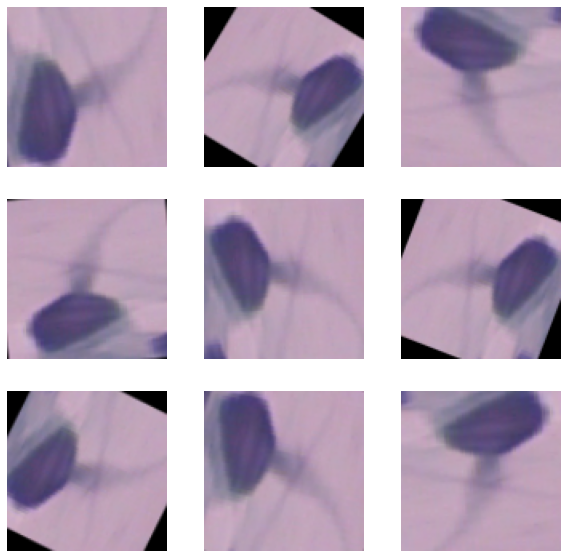

In [26]:
utils.plot_augmented(train_generator, data_augmentation)

In [27]:
base_model = tf.keras.applications.VGG19(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)
preprocess_input = tf.keras.applications.vgg19.preprocess_input
base_model.trainable = False

In [28]:
model = tf.keras.Sequential([
  tf.keras.layers.Lambda(preprocess_input, input_shape=IMG_SHAPE),
  data_augmentation,
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(OUTPUT_NEURONS, activation=OUTPUT_ACTIVATION)
])

model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)

In [29]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 100, 100, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 20,615,239
Trainable params: 590,855
Non-trainable params: 20,024,384
____________________________________

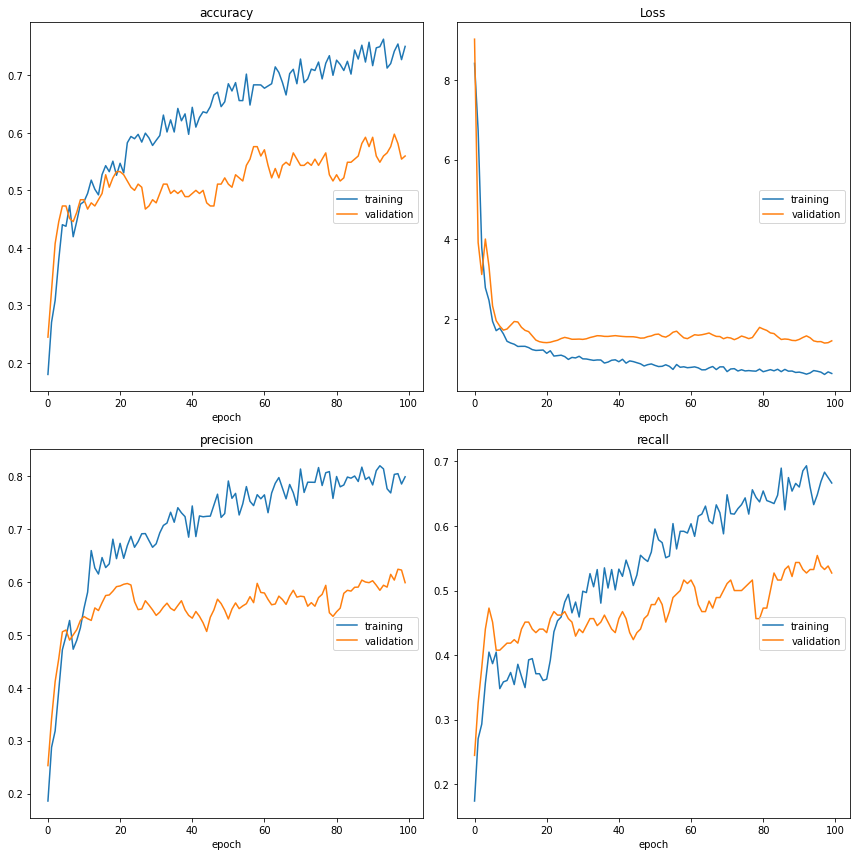

accuracy
	training         	 (min:    0.180, max:    0.763, cur:    0.751)
	validation       	 (min:    0.245, max:    0.598, cur:    0.560)
Loss
	training         	 (min:    0.617, max:    8.411, cur:    0.641)
	validation       	 (min:    1.403, max:    9.017, cur:    1.459)
precision
	training         	 (min:    0.186, max:    0.820, cur:    0.799)
	validation       	 (min:    0.253, max:    0.624, cur:    0.599)
recall
	training         	 (min:    0.174, max:    0.693, cur:    0.667)
	validation       	 (min:    0.245, max:    0.554, cur:    0.527)


In [30]:
history = model.fit(
  train_generator,
  validation_data=val_generator,
  callbacks=[PlotLossesKerasTF()],
  epochs=EPOCHS,
  steps_per_epoch=train_generator.n // train_generator.batch_size,
  validation_steps=val_generator.n // val_generator.batch_size
)

In [31]:
evaluations = model.evaluate(val_generator, verbose=0)

for evaluation, metric_name in zip(evaluations, model.metrics_names):
  print(f"{metric_name}: {evaluation}")

loss: 1.4591041803359985
accuracy: 0.5597826242446899
precision: 0.5987654328346252
recall: 0.5271739363670349


In [32]:
base_model = tf.keras.applications.resnet.ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)
preprocess_input = tf.keras.applications.resnet.preprocess_input
base_model.trainable = False

In [33]:
model = tf.keras.Sequential([
  tf.keras.layers.Lambda(preprocess_input, input_shape=IMG_SHAPE),
  data_augmentation,
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(OUTPUT_NEURONS, activation=OUTPUT_ACTIVATION)
])

model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)

In [34]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 100, 100, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 903       
Total params: 27,783,047
Trainable params: 4,195,335
Non-trainable params: 23,587,712
__________________________________

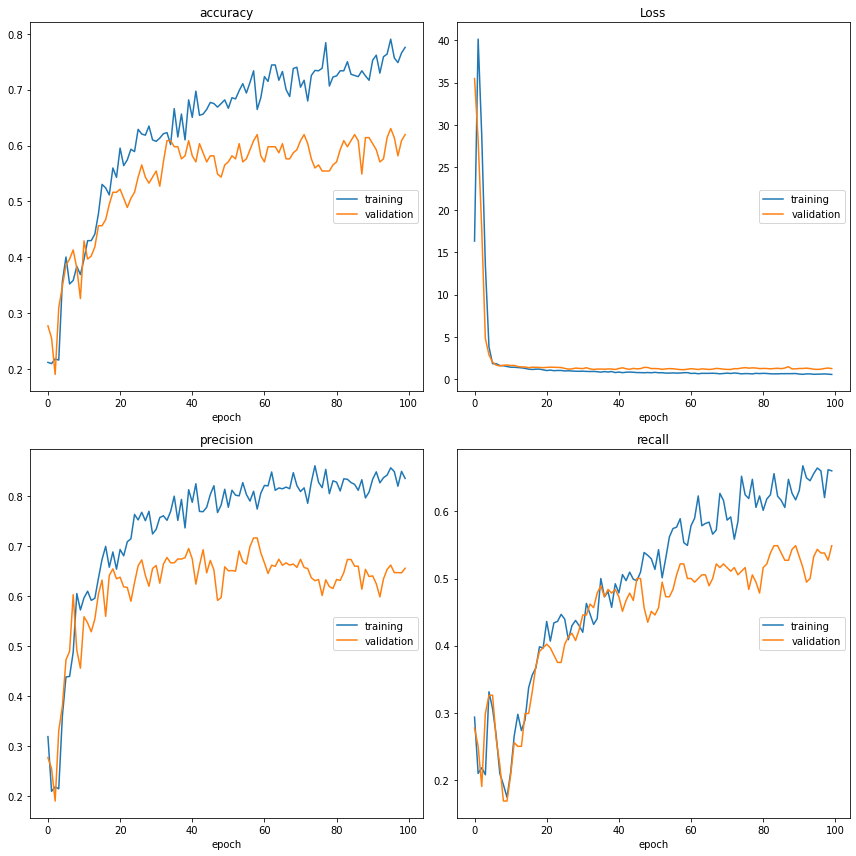

accuracy
	training         	 (min:    0.210, max:    0.790, cur:    0.776)
	validation       	 (min:    0.190, max:    0.630, cur:    0.620)
Loss
	training         	 (min:    0.594, max:   40.117, cur:    0.594)
	validation       	 (min:    1.153, max:   35.472, cur:    1.282)
precision
	training         	 (min:    0.210, max:    0.861, cur:    0.836)
	validation       	 (min:    0.190, max:    0.716, cur:    0.656)
recall
	training         	 (min:    0.174, max:    0.668, cur:    0.660)
	validation       	 (min:    0.168, max:    0.549, cur:    0.549)


In [35]:
history = model.fit(
  train_generator,
  validation_data=val_generator,
  callbacks=[PlotLossesKerasTF()],
  epochs=EPOCHS,
  steps_per_epoch=train_generator.n // train_generator.batch_size,
  validation_steps=val_generator.n // val_generator.batch_size
)

In [36]:
evaluations = model.evaluate(val_generator, verbose=0)

for evaluation, metric_name in zip(evaluations, model.metrics_names):
  print(f"{metric_name}: {evaluation}")

loss: 1.2818603515625
accuracy: 0.6195651888847351
precision: 0.6558441519737244
recall: 0.5489130616188049


In [37]:
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
base_model.trainable = False

In [38]:
model = tf.keras.Sequential([
  tf.keras.layers.Lambda(preprocess_input, input_shape=IMG_SHAPE),
  data_augmentation,
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(OUTPUT_NEURONS, activation=OUTPUT_ACTIVATION)
])

model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)

In [39]:
plotlosses = PlotLossesKerasTF()

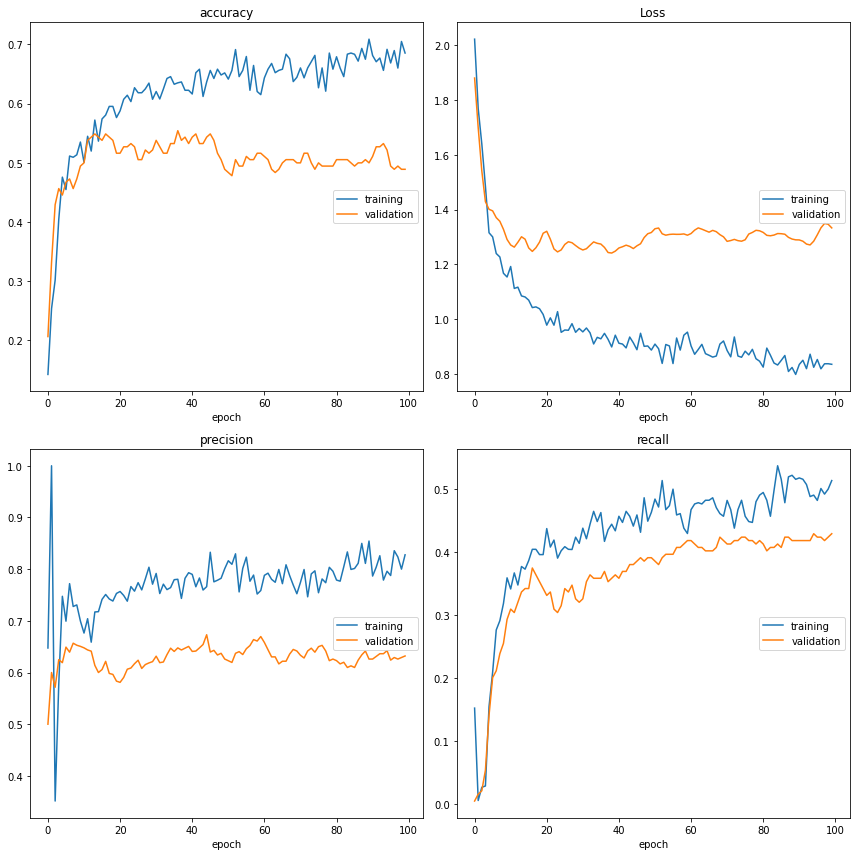

accuracy
	training         	 (min:    0.143, max:    0.709, cur:    0.686)
	validation       	 (min:    0.207, max:    0.554, cur:    0.489)
Loss
	training         	 (min:    0.799, max:    2.022, cur:    0.836)
	validation       	 (min:    1.241, max:    1.880, cur:    1.333)
precision
	training         	 (min:    0.351, max:    1.000, cur:    0.828)
	validation       	 (min:    0.500, max:    0.673, cur:    0.632)
recall
	training         	 (min:    0.006, max:    0.537, cur:    0.514)
	validation       	 (min:    0.005, max:    0.429, cur:    0.429)


In [40]:
history = model.fit(
  train_generator,
  validation_data=val_generator,
  callbacks=[plotlosses],
  epochs=EPOCHS,
  steps_per_epoch=train_generator.n // train_generator.batch_size,
  validation_steps=val_generator.n // val_generator.batch_size
)

In [41]:
evaluations = model.evaluate(val_generator, verbose=0)

for evaluation, metric_name in zip(evaluations, model.metrics_names):
  print(f"{metric_name}: {evaluation}")

loss: 1.3331094980239868
accuracy: 0.489130437374115
precision: 0.6320000290870667
recall: 0.42934781312942505


In [42]:
print("Número de capas en el modelo: ", len(base_model.layers))

Número de capas en el modelo:  237


In [43]:
base_model.trainable = True
fine_tune_at = 60


for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [44]:
tuning_learning_rate = LEARNING_RATE/10
print(tuning_learning_rate)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=tuning_learning_rate),
              loss=LOSS,
              metrics=METRICS)

0.0001


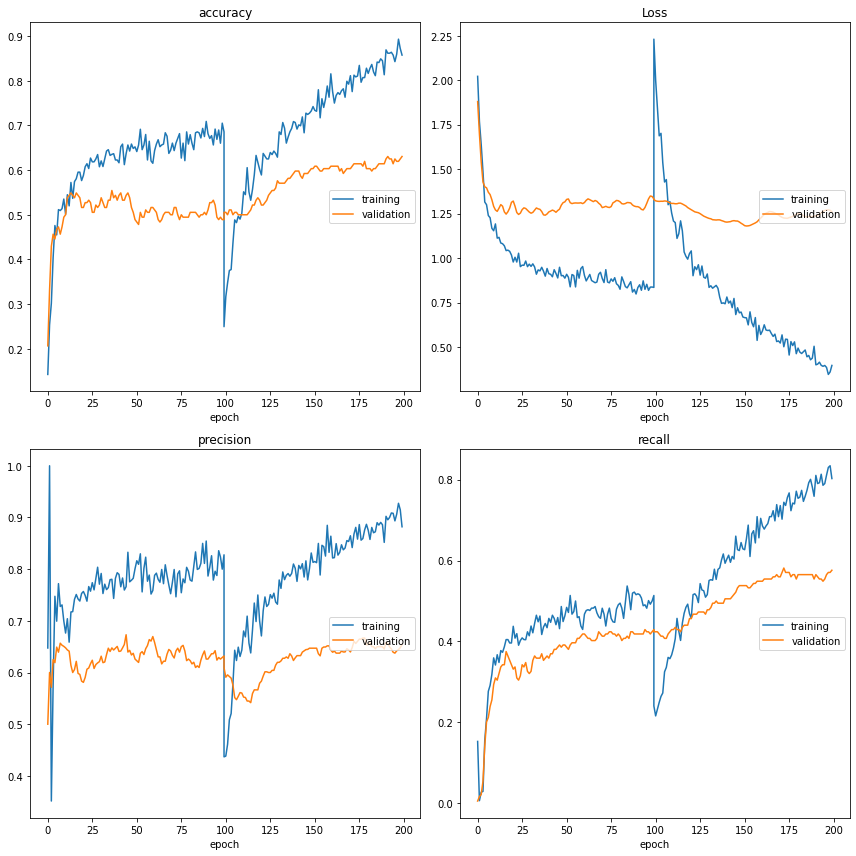

accuracy
	training         	 (min:    0.143, max:    0.893, cur:    0.857)
	validation       	 (min:    0.207, max:    0.630, cur:    0.630)
Loss
	training         	 (min:    0.346, max:    2.231, cur:    0.397)
	validation       	 (min:    1.181, max:    1.880, cur:    1.260)
precision
	training         	 (min:    0.351, max:    1.000, cur:    0.882)
	validation       	 (min:    0.500, max:    0.673, cur:    0.654)
recall
	training         	 (min:    0.006, max:    0.834, cur:    0.803)
	validation       	 (min:    0.005, max:    0.582, cur:    0.576)


In [45]:
fine_tune_epochs = 100
total_epochs = EPOCHS + fine_tune_epochs

history_fine_tuning = model.fit(
  train_generator,
  validation_data=val_generator,
  callbacks=[plotlosses],
  epochs=total_epochs,
  initial_epoch=history.epoch[-1],
  steps_per_epoch=train_generator.n // train_generator.batch_size,
  validation_steps=val_generator.n // val_generator.batch_size
)

In [46]:
evaluations = model.evaluate(val_generator, verbose=0)

for evaluation, metric_name in zip(evaluations, model.metrics_names):
  print(f"{metric_name}: {evaluation}")

loss: 1.2602006196975708
accuracy: 0.6304348111152649
precision: 0.654321014881134
recall: 0.5760869383811951


In [47]:
raw_pred = model.predict(val_generator)

In [48]:
pred = np.argmax(raw_pred, axis=1)

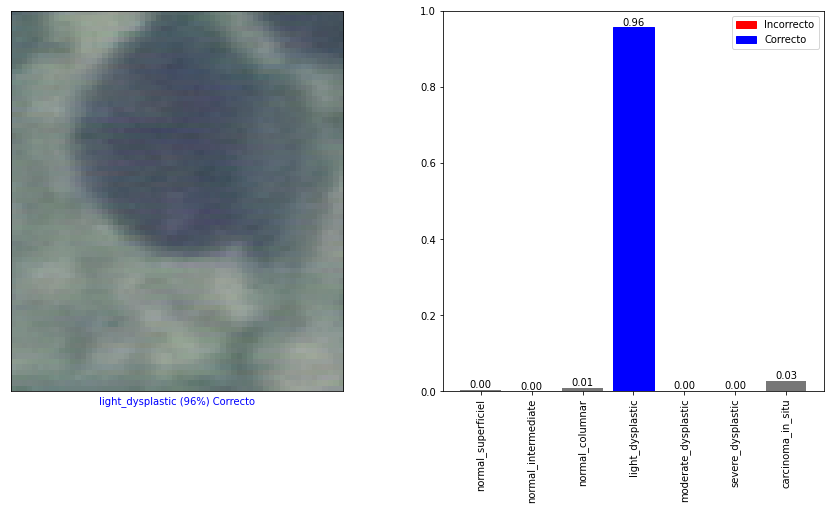

In [62]:
i = 180
utils.plot_softmax(i, raw_pred[i], val_generator.labels, val_generator.filenames, class_names)

In [50]:
df_pred = pd.DataFrame({"Real": val_generator.labels, "Pred": pred})
df_pred = df_pred.replace(utils.map_7_classes)
df_pred.head()

,Real,Pred
0,carcinoma_in_situ,light_dysplastic
1,light_dysplastic,light_dysplastic
2,moderate_dysplastic,moderate_dysplastic
3,light_dysplastic,light_dysplastic
4,severe_dysplastic,severe_dysplastic


In [51]:
df_error = df_pred[df_pred["Real"] != df_pred["Pred"]]
print(len(df_error.index))

68


In [52]:
df_error.groupby("Pred").size()

Pred
carcinoma_in_situ       7
light_dysplastic       13
moderate_dysplastic     3
normal_columnar         9
normal_intermediate    33
normal_superficiel      3
dtype: int64

In [53]:
cm = ConfusionMatrix(actual_vector=df_pred["Real"].values, predict_vector=df_pred["Pred"].values)
print(cm)

Predict                   carcinoma_in_situ         light_dysplastic          moderate_dysplastic       normal_columnar           normal_intermediate       normal_superficiel        severe_dysplastic         
Actual
carcinoma_in_situ         16                        7                         0                         5                         9                         3                         0                         

light_dysplastic          1                         13                        0                         2                         4                         0                         0                         

moderate_dysplastic       0                         0                         14                        0                         0                         0                         0                         

normal_columnar           0                         1                         0                         13                        15                      

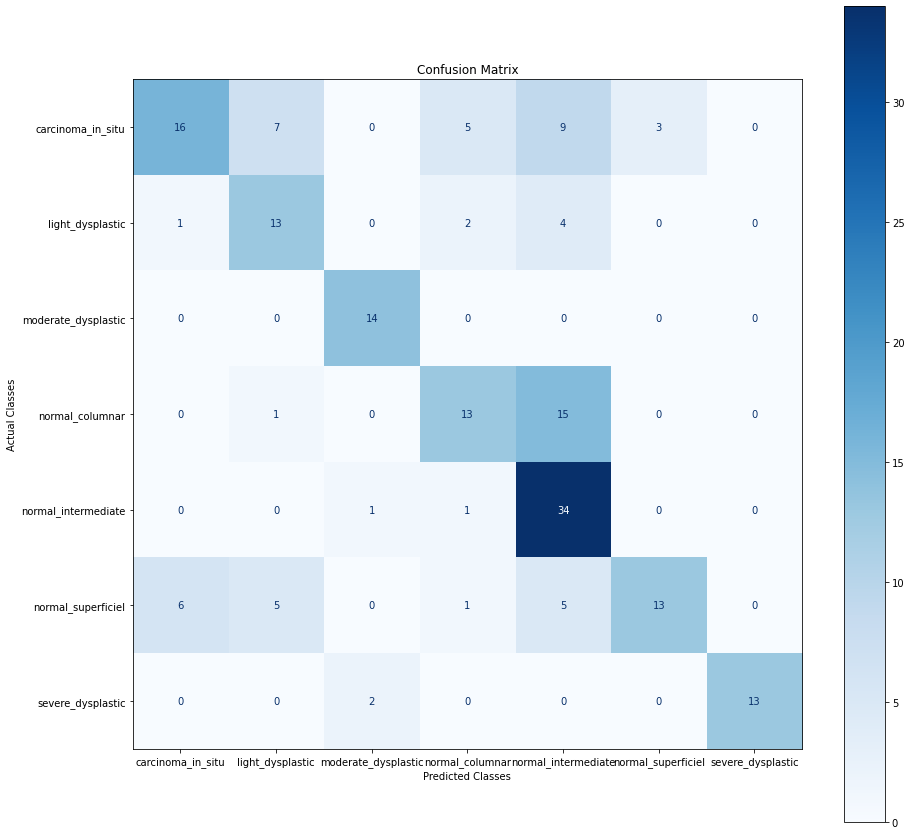

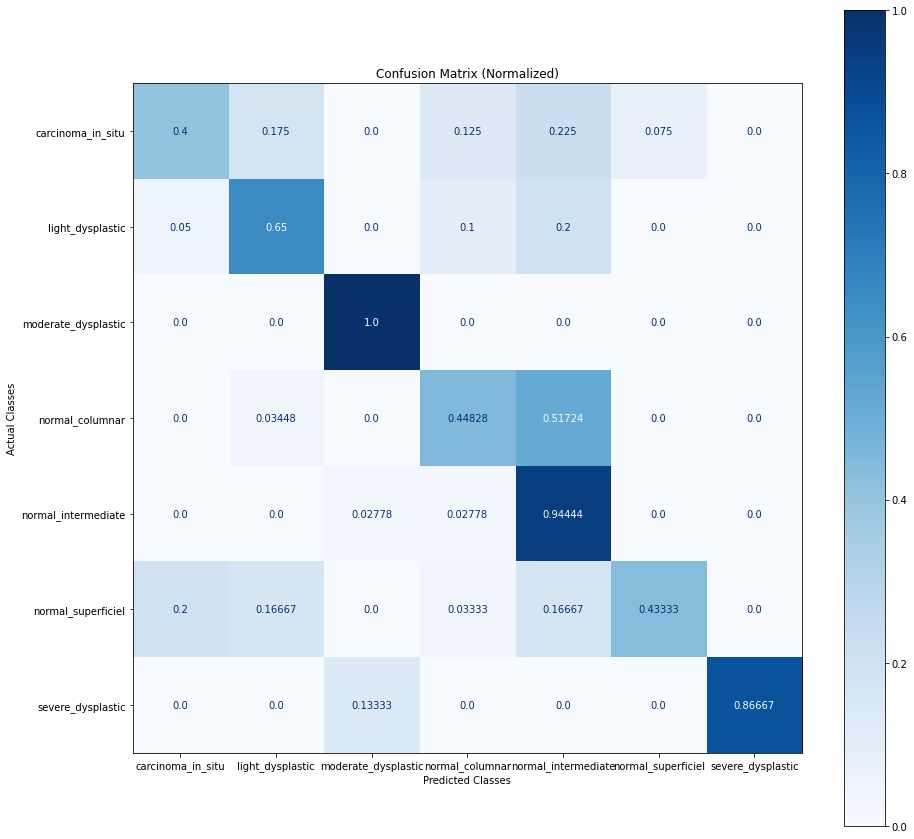

In [57]:
plt.rcParams.update({'figure.figsize': (15,15)})
cm.plot(cmap=plt.cm.Blues, number_label=True);
cm.plot(cmap=plt.cm.Blues, number_label=True, normalized=True);

In [56]:
utils.plot_roc_multiclass(df_pred, class_list = dataset["Class_cat_7"].unique())

AttributeError: module 'utils' has no attribute 'plot_roc_multiclass'

In [ ]:
utils.plot_precision_recall_curve_multiclass(df_pred, class_list = dataset["Class_cat_7"].unique())